In [11]:
%%capture
!pip install transformers
!pip install -U sentence-transformers
!pip install datasets
!pip install evaluate
!pip install googletrans==3.1.0a0

from google.colab import drive
drive.mount('/content/drive')

Load the dataset and remove string noise

In [12]:
import pandas as pd

recipes = pd.read_csv("/content/drive/MyDrive/Semantics In Intelligent Information Access/GPT trial/dataset_covered_recipes.csv", 
                          delimiter=';', 
                          quotechar='"', 
                          header=0, 
                          index_col = 0)

recipes = recipes.rename(columns={"SUSTAINABILITY": "sustainability"})
recipes['sustainability'] = recipes['sustainability'].str.lower()

# remove empty rows
# recipes = recipes[recipes["sustainability"].astype(str).str.len() != 0]
recipes = recipes.dropna(subset=['sustainability'])
display(recipes.head())

valori_unici = recipes['sustainability'].unique()
print('\n',valori_unici)

,title,url,ingredients,sustainability
recipe_id,,,,
39637,Sally's Coleslaw Dressing Recipe,http://cookeatshare.com/recipes/sally-s-colesl...,cabagge,high
28634,Canning Pumpkin,http://www.food.com/recipe/canning-pumpkin-395684,pumpkin,high
2427,Pumpkin Puree,http://cooking.nytimes.com/recipes/4333,pumpkin,high
19530,Grilled ORE-IDA Roasted Original Potatoes,http://www.kraftrecipes.com/recipes/grilled-or...,potato,high
7258,Baked Potato Toppings Recipe,http://cookeatshare.com/recipes/baked-potato-t...,potato,high



 ['high' 'medium' 'low']


In [13]:
import numpy as np

rec_perc = recipes.loc[:, ["title","ingredients", "sustainability"]].copy()
# rec_perc['text'] = rec_perc['title'] + ' ' + rec_perc['ingredients']
rec_perc['text'] = rec_perc['ingredients']
rec_perc.drop(['title', 'ingredients'], axis=1, inplace=True)
rec_perc.rename(columns={'sustainability': 'label'}, inplace=True)
rec_ft = rec_perc
display(rec_perc)

,label,text
recipe_id,,
39637,high,cabagge
28634,high,pumpkin
2427,high,pumpkin
19530,high,potato
7258,high,potato
...,...,...
38574,low,"olive oil,sesame oil,garlic powder,plum,soy sa..."
31046,low,"dark chocolate,olive oil,garlic powder,lime ju..."
39216,low,"red pepper or cayenne spices,fresh parsley,cor..."


sustainability
high       6323
low         720
medium    16459
dtype: int64

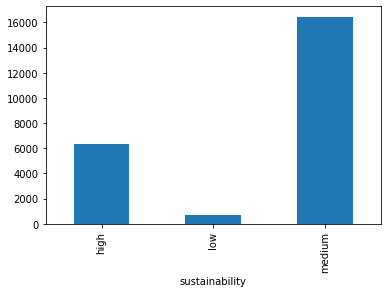

In [14]:
recipes.groupby("sustainability").size().plot.bar()
recipes.groupby("sustainability").size()

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

Number of tokens for 'low': 3
Number of tokens for 'medium': 3
Number of tokens for 'high': 3


label
0     6323
1      720
2    16459
dtype: int64

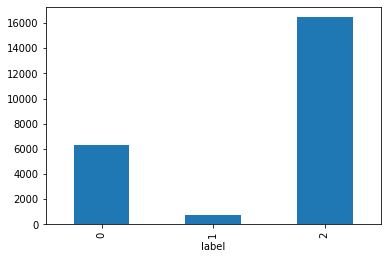

In [15]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer.pad_token = tokenizer.eos_token

low_encoded = tokenizer.encode("low")
medium_encoded = tokenizer.encode("medium")
high_encoded = tokenizer.encode("high")

print(f"Number of tokens for 'low': {len(low_encoded)}")
print(f"Number of tokens for 'medium': {len(medium_encoded)}")
print(f"Number of tokens for 'high': {len(high_encoded)}")

rec_ft.reset_index(drop=True, inplace=True)
rec_ft['label'] = pd.Categorical(rec_ft['label']).codes

rec_ft.groupby("label").size().plot.bar()
rec_ft.groupby("label").size()

# Model are able to learn (and classify)

In [16]:
from transformers import pipeline, set_seed
from datasets import Dataset, DatasetDict

import numpy as np
from sklearn.model_selection import train_test_split

# create an array with the indices of the examples in the DataFrame
indices = np.arange(len(rec_ft))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# create a boolean mask to select the examples in train and test
train_mask = np.isin(indices, train_indices)
test_mask = np.isin(indices, test_indices)

# create the train and test DataFrames using the masks
train_data = rec_ft[train_mask]
test_data = rec_ft[test_mask]

# group the train and test data by label
train_grouped = train_data.groupby('label')
test_grouped = test_data.groupby('label')

# sample the examples for each group (i.e., class) without replacement using the indices
train_examples = []
test_examples = []
for name, group in train_grouped:
    train_examples.append(group.sample(n=480, random_state=42))
for name, group in test_grouped:
    test_examples.append(group.sample(n=120, random_state=42))

# concatenate the examples into train and test DataFrames
train_data = pd.concat(train_examples)
test_data = pd.concat(test_examples)

train_dataset = Dataset.from_pandas(train_data)#, split='train')
test_dataset = Dataset.from_pandas(test_data)

dataset_1 = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# tokenize dataset
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", max_length=100, truncation=True)

tokenized_datasets = dataset_1.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

#train_data = train_data.reset_index(drop=True)
#test_data = test_data.reset_index(drop=True)
#display(train_data)
#display(test_data)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc,}
  
# train
from transformers import RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
import psutil
import logging

# setup logging to print accuracy during training
logging.basicConfig(level=logging.INFO)

training_args = TrainingArguments(output_dir="model_weights",  num_train_epochs=5)
metric = evaluate.load("accuracy")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/ff46155979338ff8063cdad90908b498ab91b181/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514

Step,Training Loss
500,0.289600


Saving model checkpoint to model_weights/checkpoint-500
Configuration saved in model_weights/checkpoint-500/config.json
Model weights saved in model_weights/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=900, training_loss=0.20819472842746312, metrics={'train_runtime': 168.9499, 'train_samples_per_second': 42.616, 'train_steps_per_second': 5.327, 'total_flos': 370003243680000.0, 'train_loss': 0.20819472842746312, 'epoch': 5.0})

In [18]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 360
  Batch size = 8


{'eval_loss': 0.130144864320755,
 'eval_accuracy': 0.9722222222222222,
 'eval_runtime': 2.3171,
 'eval_samples_per_second': 155.364,
 'eval_steps_per_second': 19.421,
 'epoch': 5.0}

In [19]:
# create a new DataFrame with three examples
new_examples = pd.DataFrame({
    "text": [
        "chicken breast, garlic, olive oil, salt, pepper",
        "quinoa, bell pepper, tomato, onion, lime",
        "beef, broccoli, soy sauce, brown sugar, garlic"
    ]
})

# tokenize the new examples
new_tokenized = tokenizer(new_examples["text"].tolist(), padding="max_length", max_length=100, truncation=True)

# create a Dataset from the tokenized examples
new_dataset = Dataset.from_dict(new_tokenized)

# make predictions
predictions = trainer.predict(new_dataset)

# get predicted labels
pred_labels = np.argmax(predictions.predictions, axis=1)

# convert predicted labels to sustainability labels
sustainability_labels = ["low", "medium", "high"]
pred_sustainability = [sustainability_labels[label] for label in pred_labels]

# print predictions
for i, example in enumerate(new_examples["text"]):
    print(f"Example {i+1}: {example}\nPredicted sustainability: {pred_sustainability[i]}\n")

***** Running Prediction *****
  Num examples = 3
  Batch size = 8


Example 1: chicken breast, garlic, olive oil, salt, pepper
Predicted sustainability: high

Example 2: quinoa, bell pepper, tomato, onion, lime
Predicted sustainability: low

Example 3: beef, broccoli, soy sauce, brown sugar, garlic
Predicted sustainability: medium

